In [1]:
import os
import qca
import numpy as np
import itertools as it
import matplotlib.pyplot as plt
%load_ext line_profiler

In [2]:
cmds = []
outfiles = []
ngpus = 8
ics = [1, 3, 5, 6, 7, 9, 11, 15]
rules = [10, 12]  # range(1, 33)
nqubits = 25
ncycles = 50
open_boundaries = "true"
gate_err = 0.0  # 2.0
trajectories = range(1)  # range(80)
count = 0
for trajectory in trajectories:
    trajectory = str(trajectory)
    for ic in ics:
        ic = str(ic)
        for rule in rules:
            gpu_id = count % ngpus
            rule = str(rule)
            (cmd, stdout, stderr, outfile) = qca.run.circuit.cycle(
                ncycles=str(ncycles),
                nrows="5",
                ncols="5",
                rule=rule,
                ic=ic,
                gate_mode="2",
                open_boundaries=open_boundaries,
                trajectory=trajectory,
                gate_err=str(gate_err),
                rmajor="true",
                verbose="false",
                execute=False,
                qca_root="./"
            )                                         
            cmd = f"CUDA_VISIBLE_DEVICES={gpu_id} srun {cmd} &> $SLURM_JOB_ID/{gpu_id}gpu_id.out &"
            if gpu_id == 0:
                cmd = (f"date \n\n" +
                       f"{cmd}")
            if gpu_id == ngpus - 1:
                cmd = (f"{cmd} \n\n" +
                       f"wait \n")
            count = count + 1
            cmds.append(cmd)
            outfiles.append(outfile)

preamble = ("#!/usr/bin/env bash \n" +
            "#SBATCH --job-name=qca \n" +
            "#SBATCH --nodes=1 \n" +
            "#SBATCH --exclusive \n" +
            "#SBATCH --partition=bigjob \n" +
            "#SBATCH --time=10:00:00 \n" +
            "#SBATCH --export=ALL \n" +
            "#SBATCH --output=qca.out \n" +
            "#SBATCH --error=qca.err \n" +
            "mkdir $SLURM_JOB_ID \n\n" +
            "echo \"hostname: $(hostname)\" \n\n")
postamble = ("mv qca.out $SLURM_JOB_ID/ \n" +
             "mv qca.err $SLURM_JOB_ID/ \n\n" +
             "date \n")
with open("qca.sh", "+w") as file:
    file.write(preamble)
    for cmd in cmds:
        file.write(f"{cmd} \n")
    file.write(postamble)

In [3]:
# single_qubit_files = list(it.chain.from_iterable([[outfile[0]
#                                                    for outfile in outfileset]
#                                                   for outfileset in outfiles]))
# two_qubit_files = list(it.chain.from_iterable([[outfile[1]
#                                                 for outfile in outfileset]
#                                                for outfileset in outfiles]))

In [4]:
# %%time
# single_qubit_densities = qca.read.density.qubit_densities(single_qubit_files)

In [5]:
# %%time
# two_qubit_densities = qca.read.density.qubit_densities(two_qubit_files)

In [6]:
# count = 0
# reshaped_single_qubit_densities = []
# reshaped_two_qubit_densities = []
# for trajectory in trajectories:
#     for ic in ics:
#         for rule in rules:
#             for cycle in range(ncycles):
#                 reshaped_single_qubit_densities.append((rule, ic, cycle, single_qubit_densities[count]))
#                 reshaped_two_qubit_densities.append((rule, ic, cycle, two_qubit_densities[count]))
#                 count = count + 1

In [7]:
# np.save("data/single_qubit_densities_0.00err", reshaped_single_qubit_densities)
# np.save("data/two_qubit_densities_0.00err", reshaped_two_qubit_densities)

In [8]:
single_qubit_densities = np.load("data/single_qubit_densities_0.00err.npy", allow_pickle=True)
two_qubit_densities = np.load("data/two_qubit_densities_0.00err.npy", allow_pickle=True)

In [9]:
density_index = 3
single = [single_qubit_densities[index, density_index] for index in range(len(single_qubit_densities))]
two = [two_qubit_densities[index, density_index] for index in range(len(two_qubit_densities))]

In [10]:
# %%time
# entropy_order = 2
# mutual_information = qca.read.mutual.information(single, two, entropy_order)

In [11]:
# mutual_information = [(single_qubit_densities[index, :3], mutual_information[index])
#                       for index in range(len(single_qubit_densities))]

In [12]:
# np.save("data/mutual_information_0.00err", mutual_information)

In [13]:
mutual_information = np.load("data/mutual_information_0.00err.npy", allow_pickle=True)

In [14]:
tolerance = 0
clustering = qca.read.mutual.clustering([mutual_information[index, 1]
                                         for index in range(len(mutual_information))], tolerance)

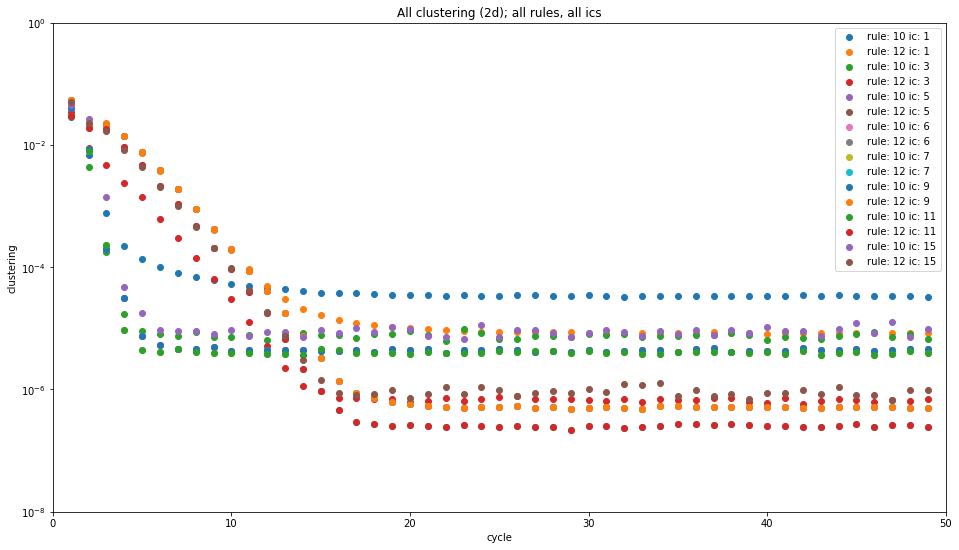

In [27]:
nsims = len(clustering) / ncycles
plt.figure(figsize=(16, 9));
plt.title("All clustering (2d); all rules, all ics")
for sim in range(int(nsims)):
    sim_rule, sim_ic, _ = list(mutual_information[int(sim*ncycles), 0])
    sim_clustering = clustering[int(sim*ncycles):int((sim+1)*ncycles)]
    plt.xlabel("cycle");
    plt.xscale("linear");
    plt.xlim(0, 50)
    plt.ylabel("clustering");
    plt.yscale("log");
    plt.ylim(1e-8, 1);
    plt.scatter(range(ncycles), sim_clustering, label=f"rule: {sim_rule} ic: {sim_ic}");
plt.legend();
# plt.savefig("2d_clustering_all_rules_all_ics.png", dpi=300)

sim_index: 0


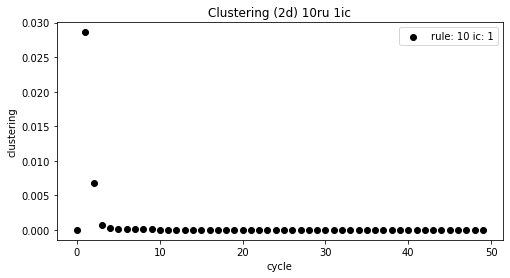

sim_index: 1


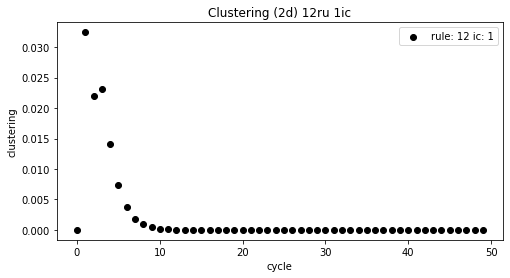

sim_index: 2


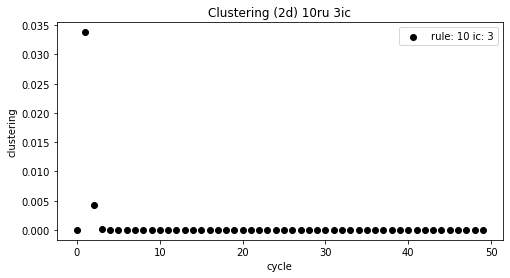

sim_index: 3


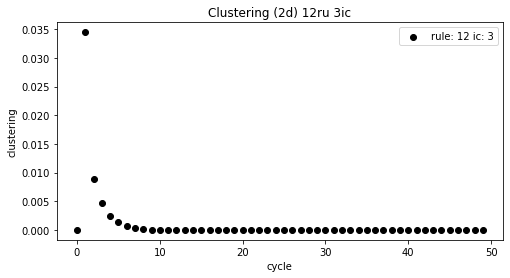

sim_index: 4


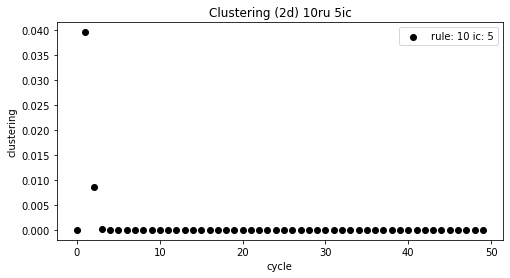

sim_index: 5


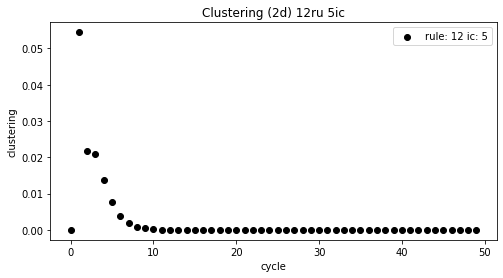

sim_index: 6


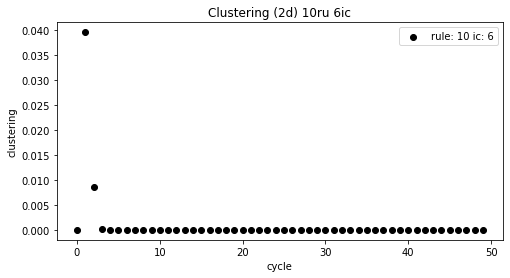

sim_index: 7


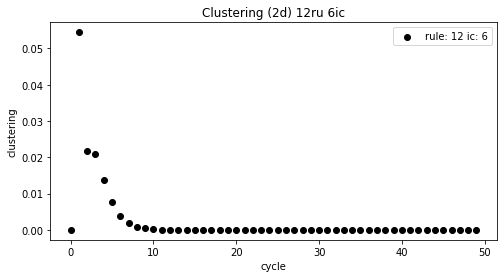

sim_index: 8


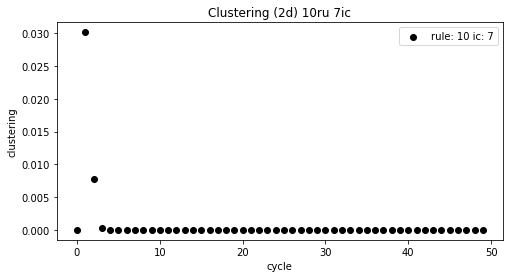

sim_index: 9


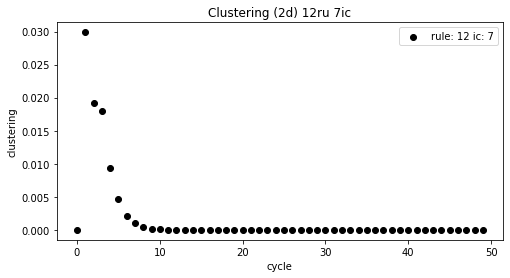

sim_index: 10


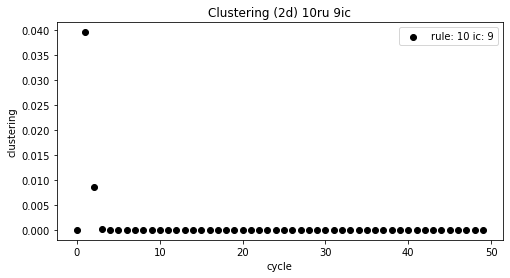

sim_index: 11


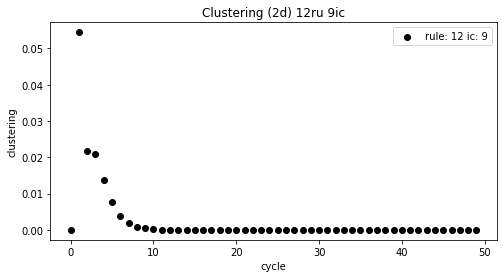

sim_index: 12


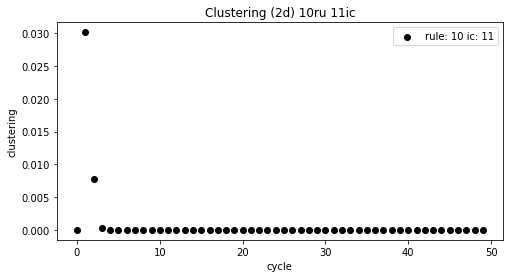

sim_index: 13


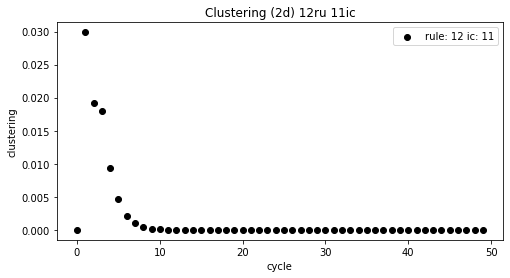

sim_index: 14


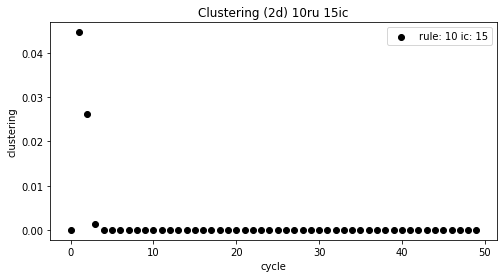

sim_index: 15


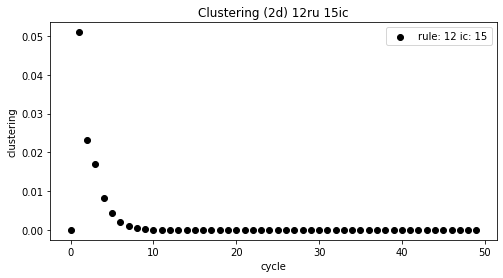

In [25]:
for sim_index in range(len(mutual_information)//ncycles):
    print(f"sim_index: {sim_index}")
    sim_rule, sim_ic, _ = list(mutual_information[int(sim_index*ncycles), 0])
    sim_clustering = clustering[int(sim_index*ncycles):int((sim_index+1)*ncycles)]
    plt.figure(figsize=(8, 4));
    plt.title(f"Clustering (2d) {sim_rule}ru {sim_ic}ic");
    plt.xlabel("cycle");
    plt.ylabel("clustering");
    plt.scatter(range(ncycles), sim_clustering, color="black", label=f"rule: {sim_rule} ic: {sim_ic}");
    plt.legend();
    plt.show();
    # plt.savefig(f"2d_clustering_{sim_rule}ru_{sim_ic}ic.png")

In [28]:
## TODO: add entropy and polarization methods to the QCA Python module
entropy_order = 2
def polarization(densities_list, index):
    polarization_list = []
    for densities in densities_list:
        pol = qca.read.mutual.polarization(densities, index)
        polarization_list.append(pol)
    return polarization_list
def _entropy(densities, alpha):
    return [qca.read.mutual._calculate_entropy(density[1], alpha)
            for density in densities]
def entropy(densities_list, alpha):
    entropy_list = []
    for densities in densities_list:
        ent = qca.read.mutual.entropy(densities, alpha)
        entropy_list.append(ent)
    return entropy_list

site_polarization = np.array(polarization(single, 1))[:, :, 1]
site_entropy = np.array(entropy(single, entropy_order))[:, :, 1]

<ipython-input-28-c2b554bfaaf8>:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  site_polarization = np.array(polarization(single, 1))[:, :, 1]
<ipython-input-28-c2b554bfaaf8>:20: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  site_entropy = np.array(entropy(single, entropy_order))[:, :, 1]


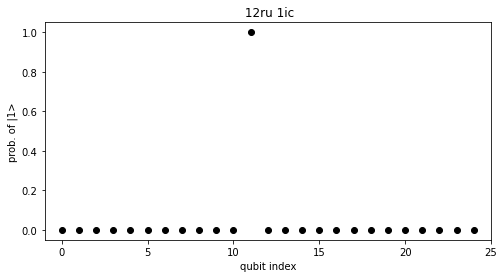

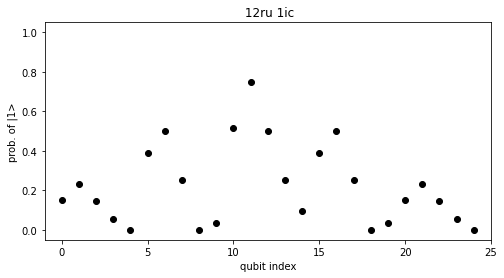

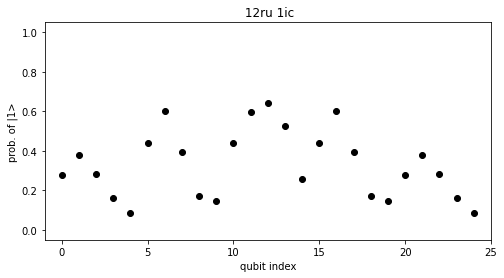

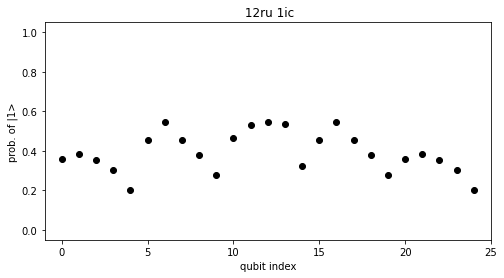

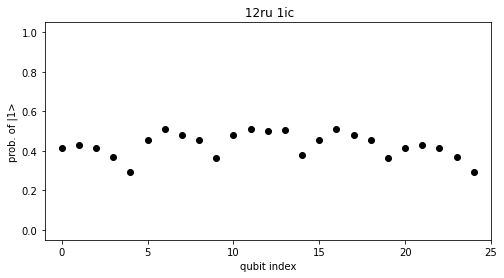

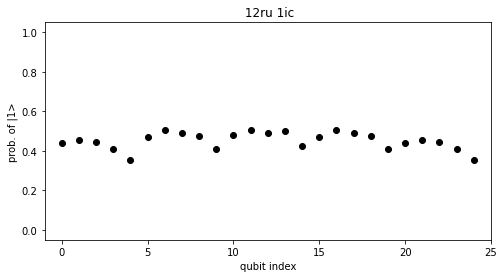

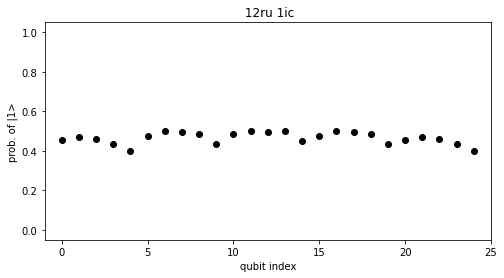

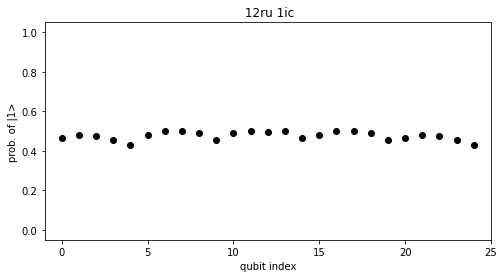

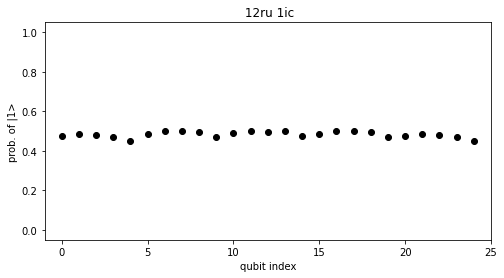

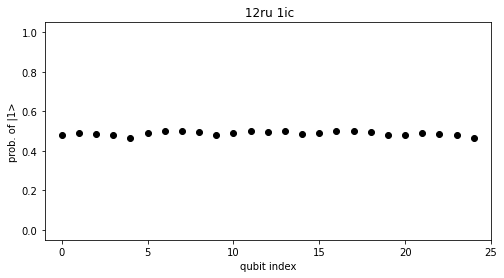

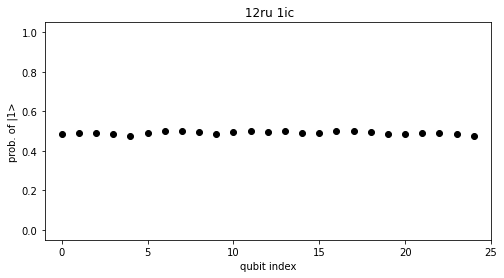

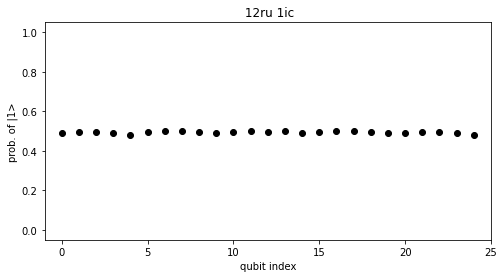

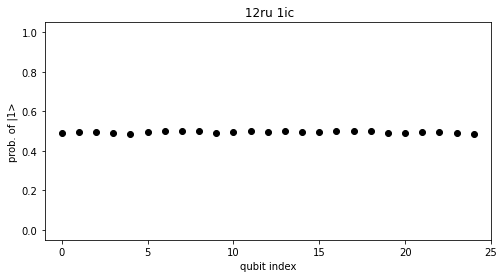

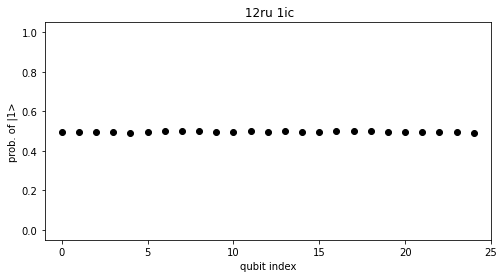

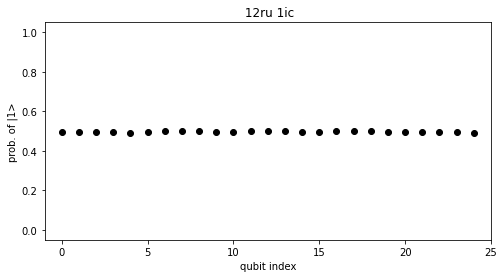

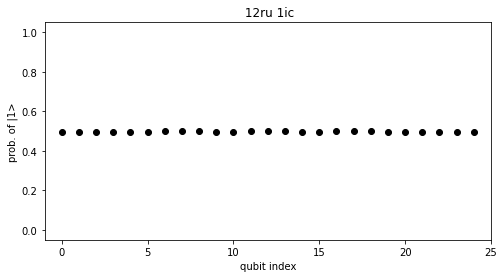

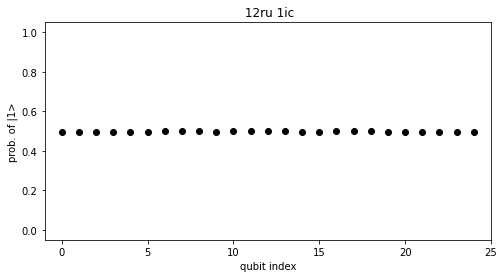

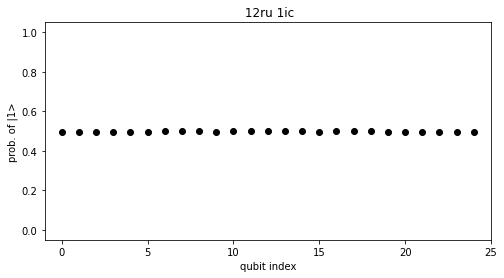

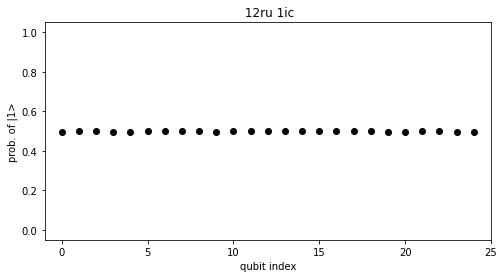

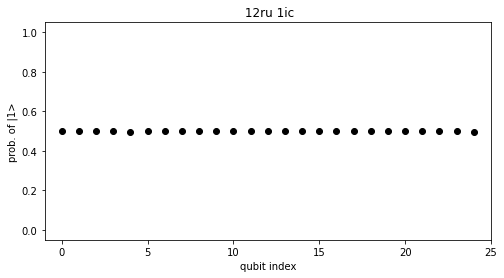

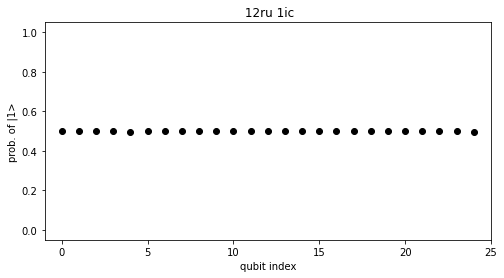

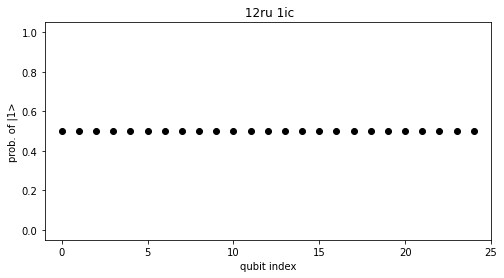

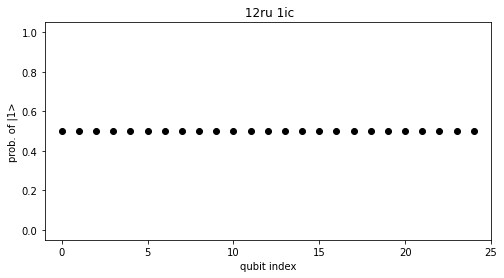

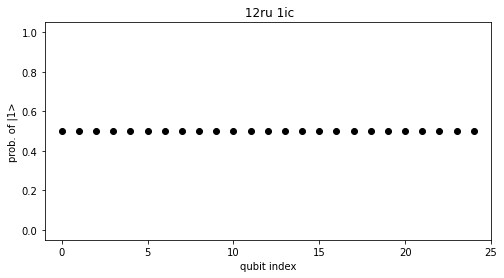

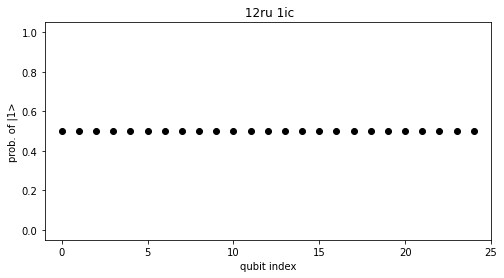

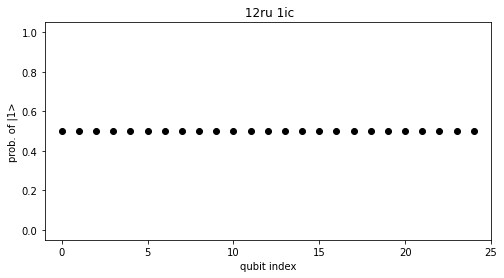

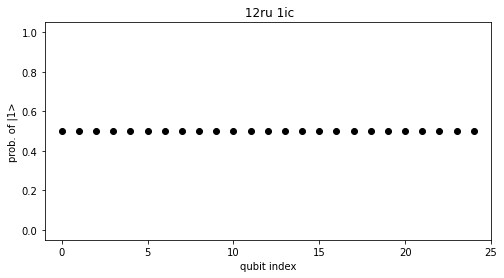

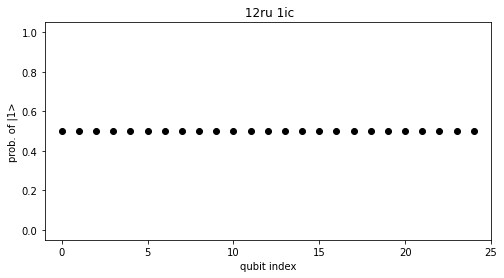

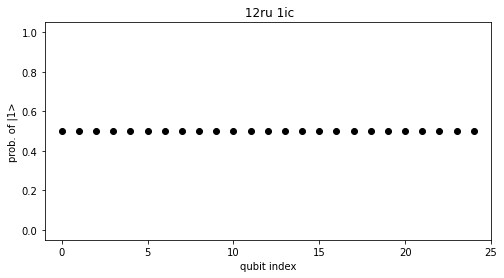

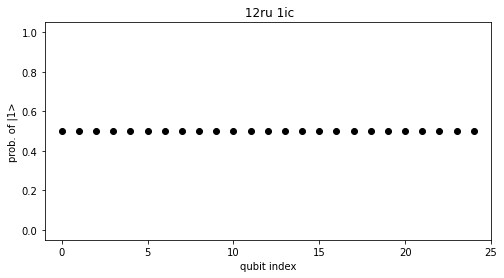

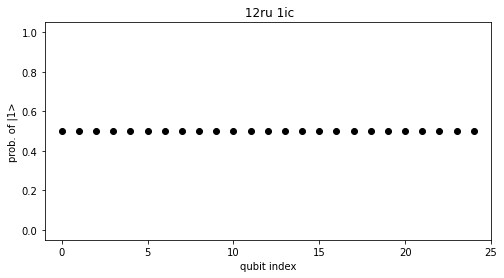

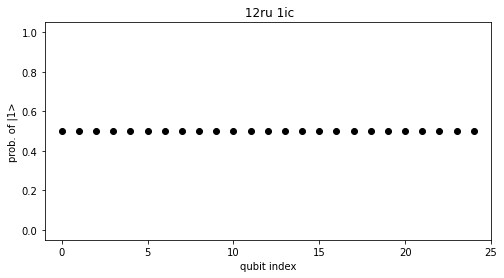

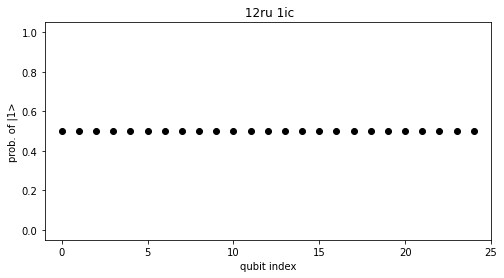

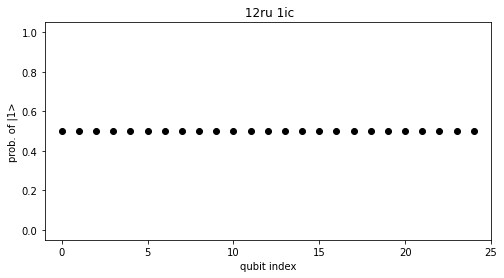

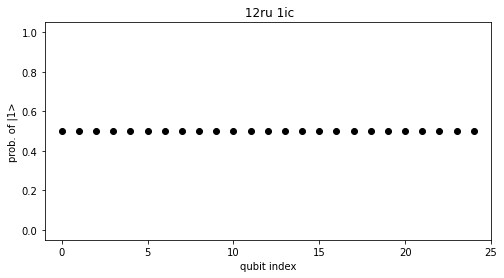

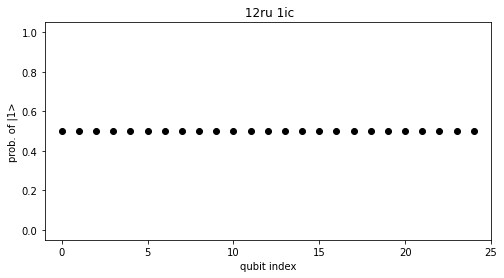

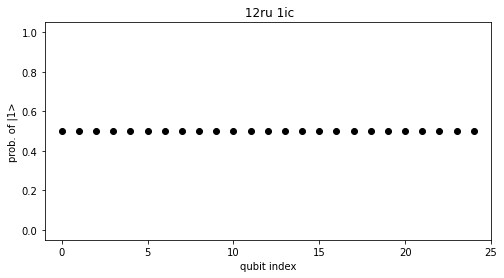

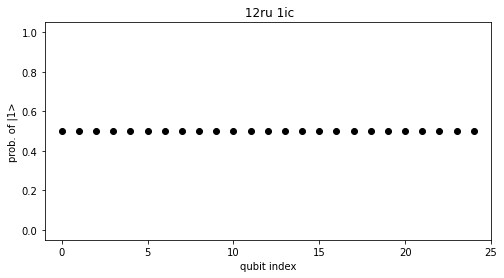

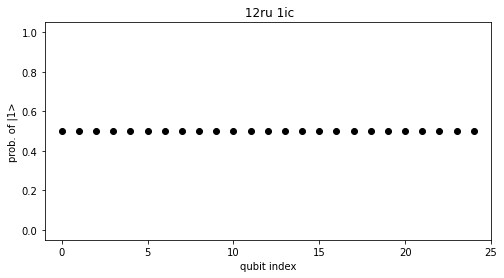

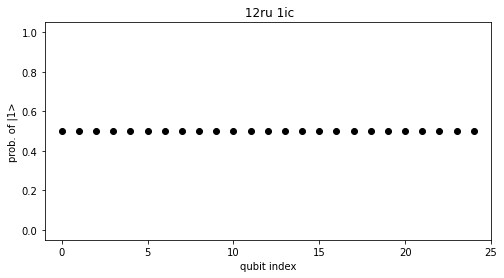

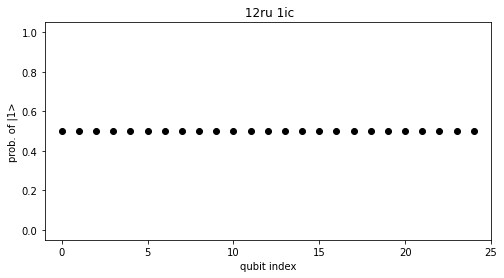

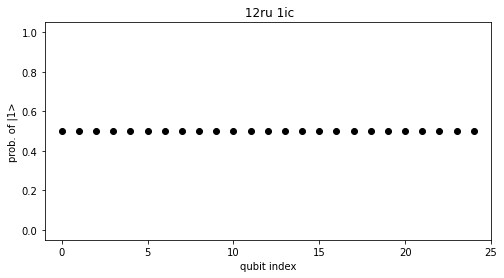

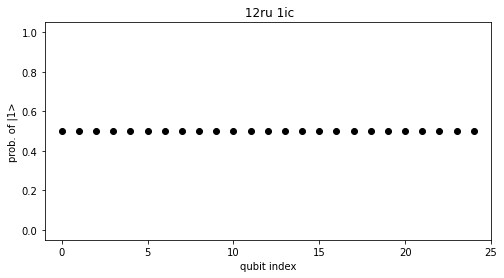

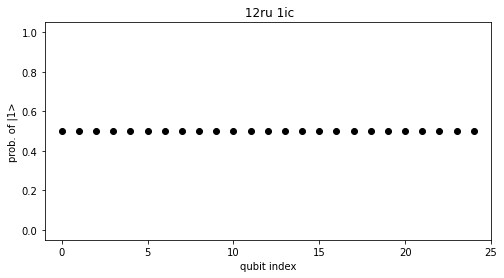

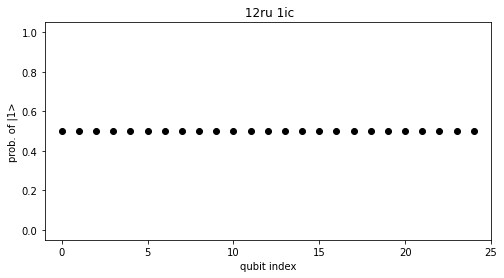

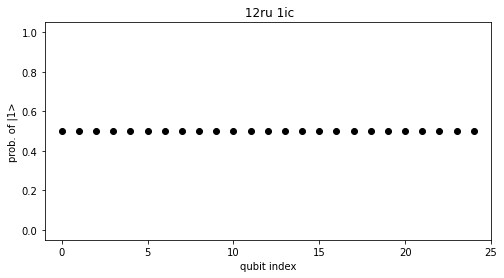

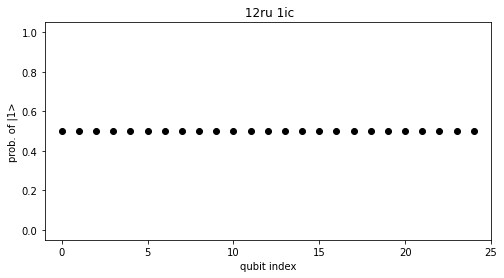

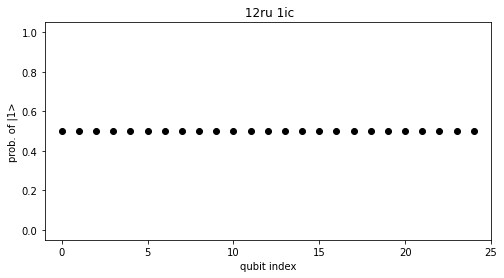

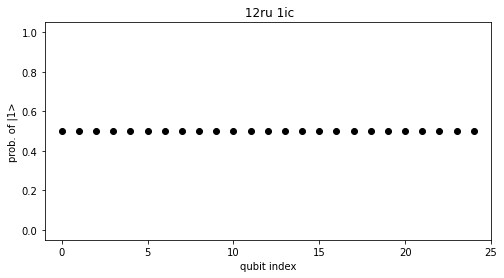

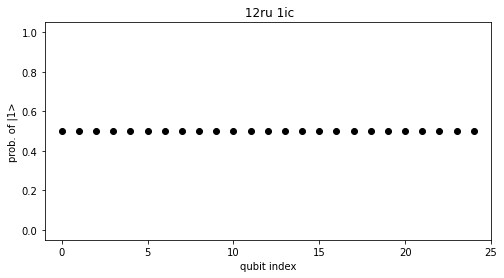

In [34]:
sim_index = 1  # 238, 239 are interesting
sim_rule, sim_ic, _ = list(mutual_information[int(sim_index*ncycles), 0])
sim_polarization = site_polarization[int(sim_index*ncycles):int((sim_index+1)*ncycles)]
for cycle in range(ncycles):
    plt.figure(figsize=(8, 4));
    plt.title(f" {sim_rule}ru {sim_ic}ic")
    plt.xlabel("qubit index");
    plt.xlim(-1, 25);
    plt.ylabel("prob. of |1>");
    plt.ylim(-0.05, 1.05);
    plt.scatter(range(nqubits), np.abs(sim_polarization[cycle]), color="black");
#     plt.savefig(f"gifs/spin/Site_spin_{sim_rule}ru_{sim_ic}ic_{cycle}cycle.png");
    plt.show()

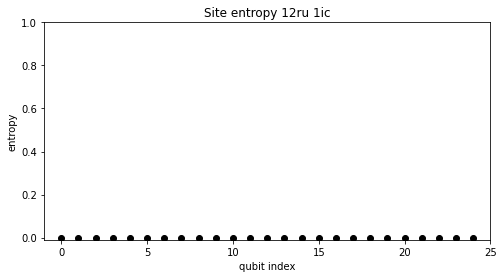

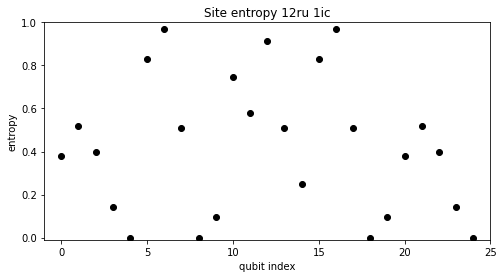

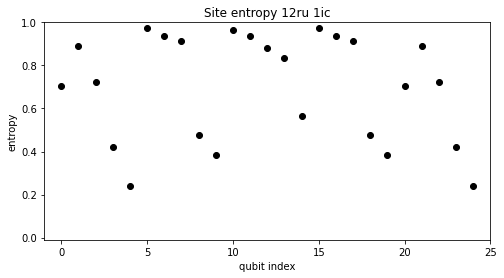

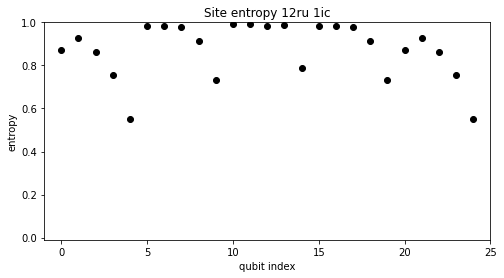

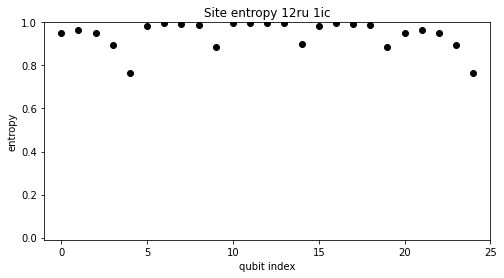

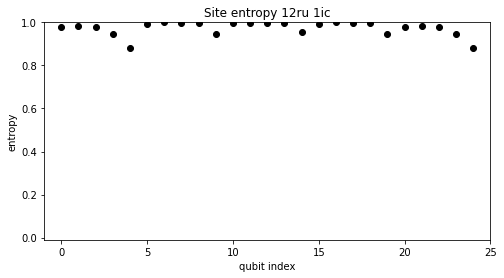

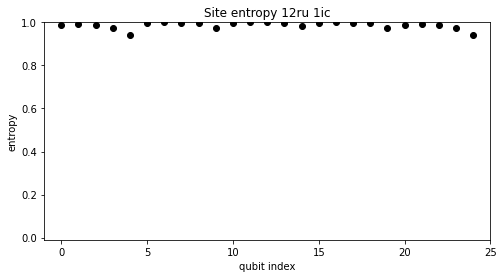

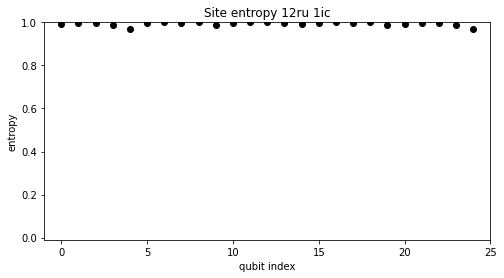

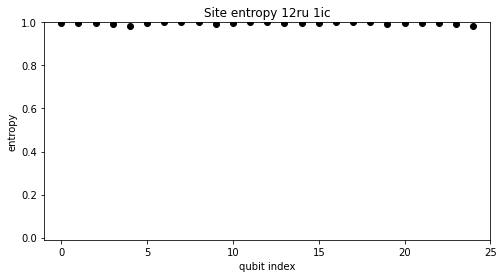

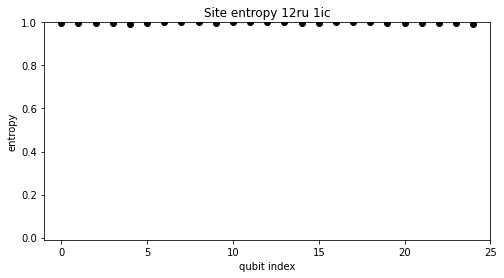

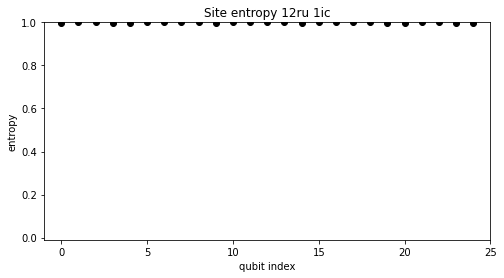

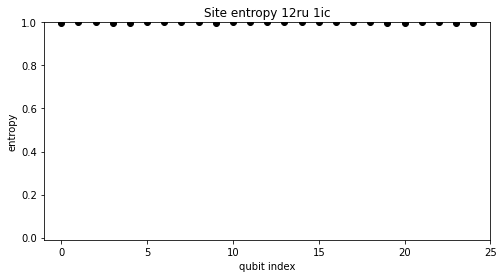

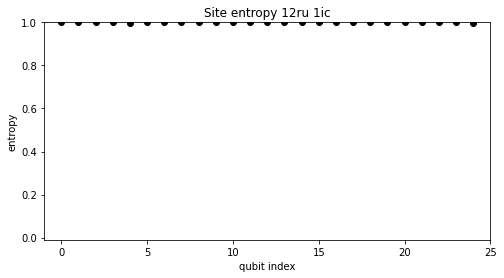

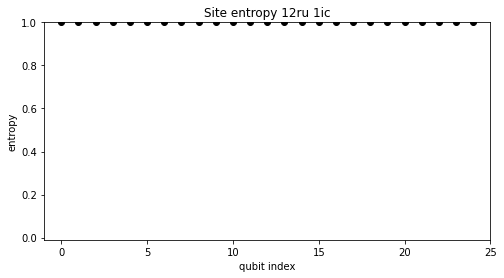

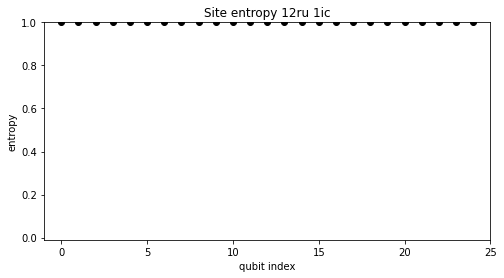

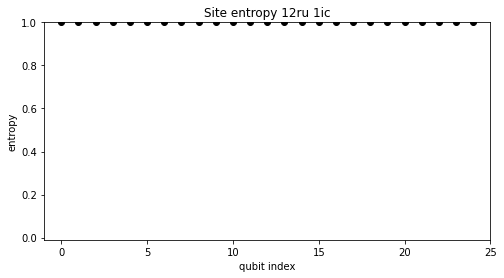

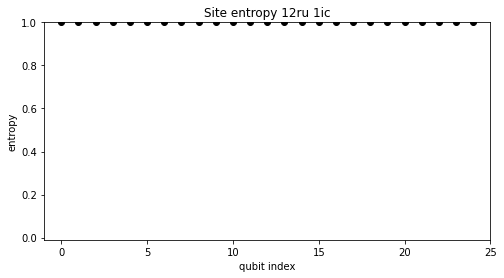

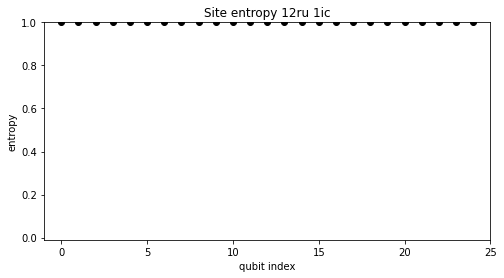

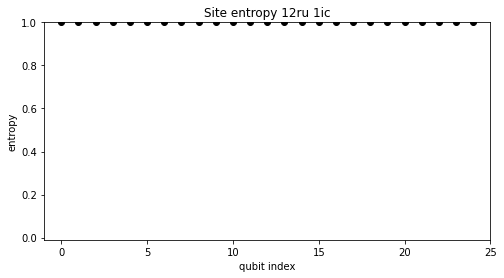

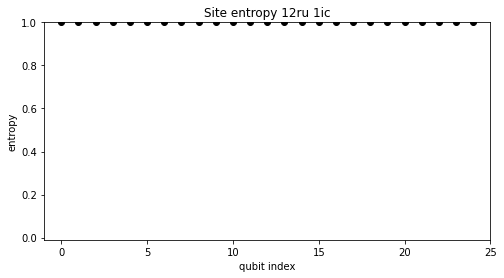

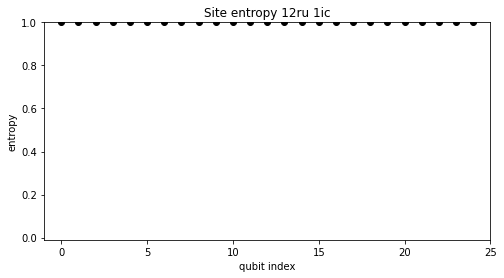

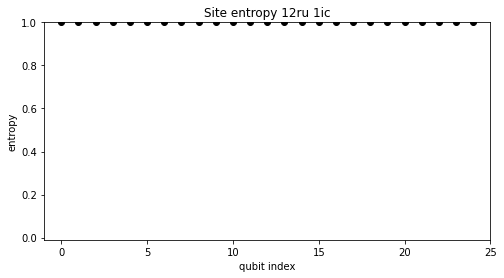

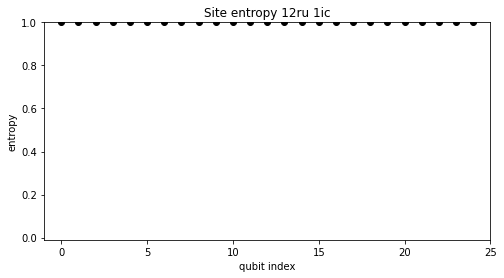

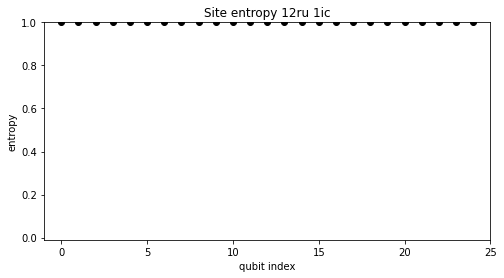

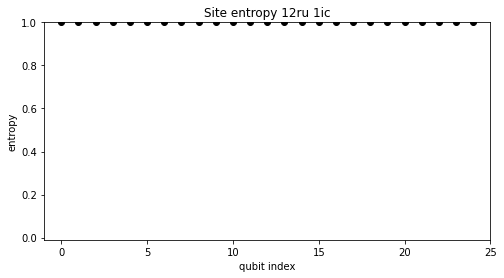

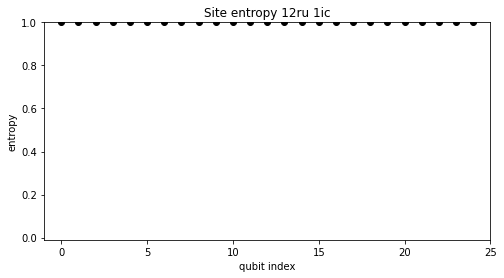

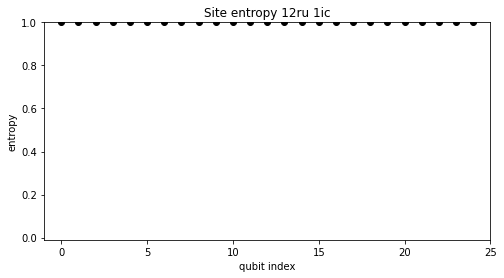

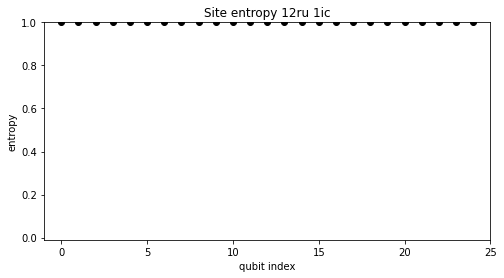

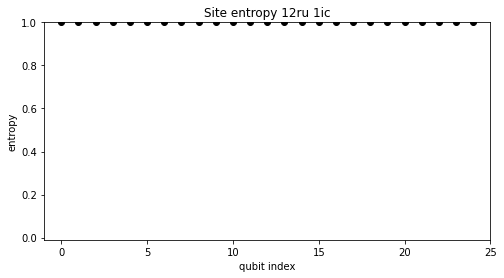

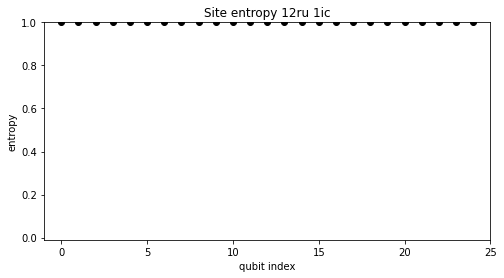

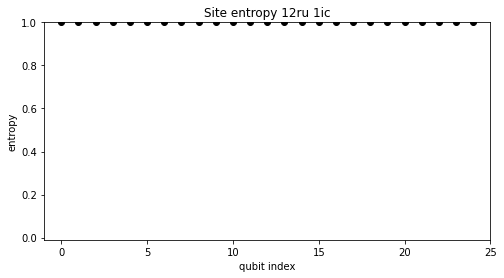

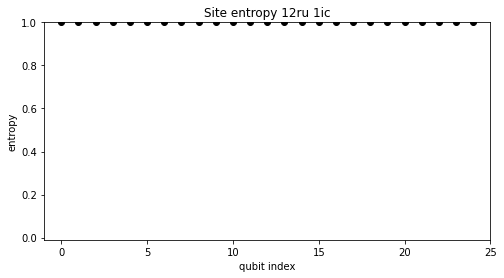

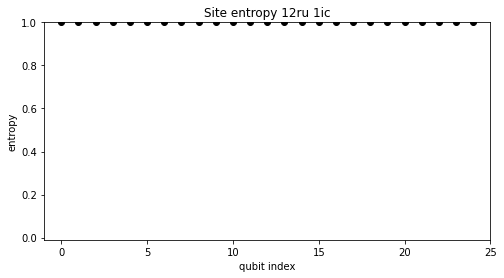

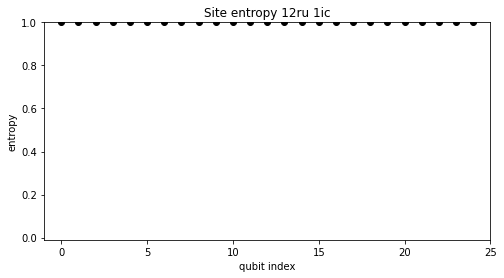

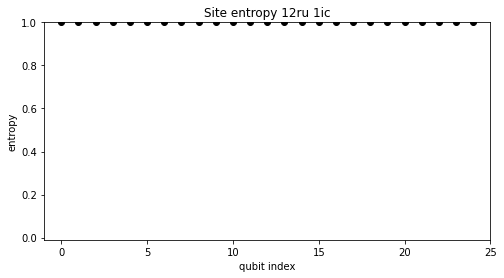

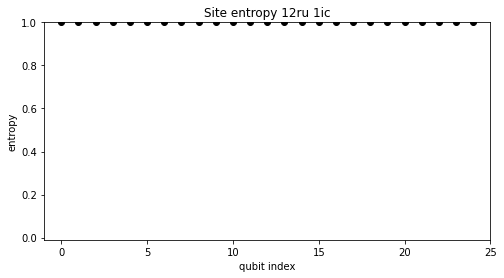

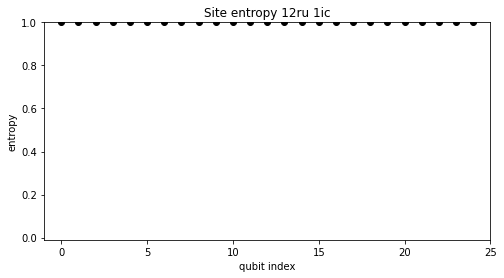

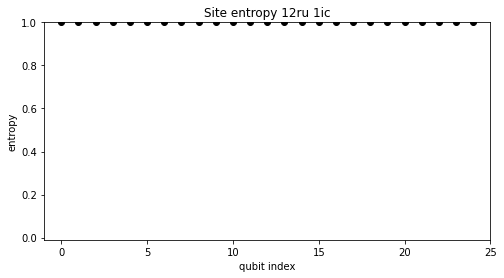

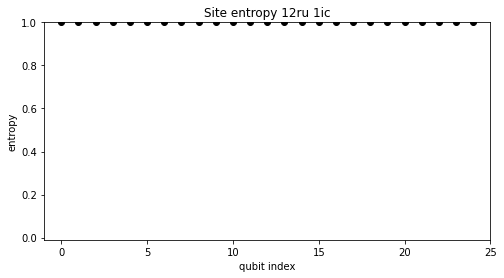

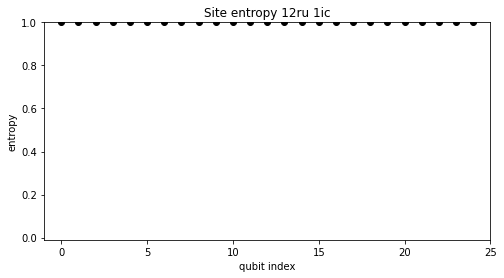

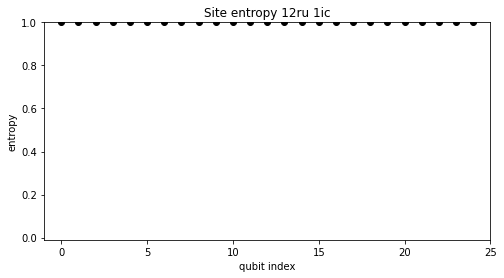

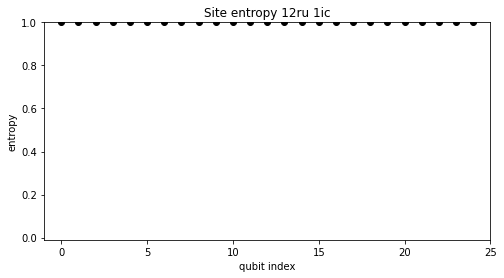

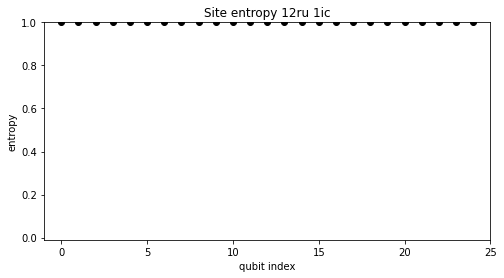

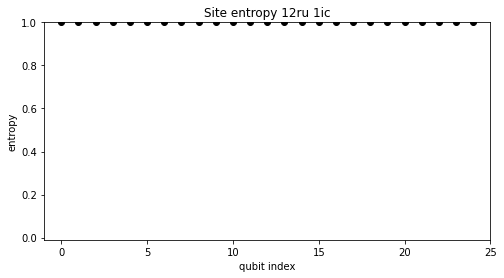

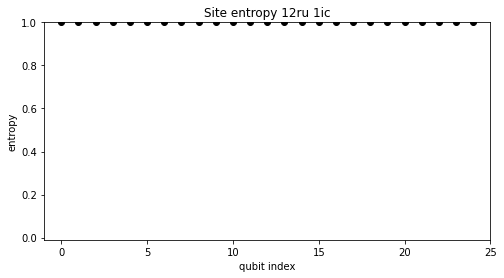

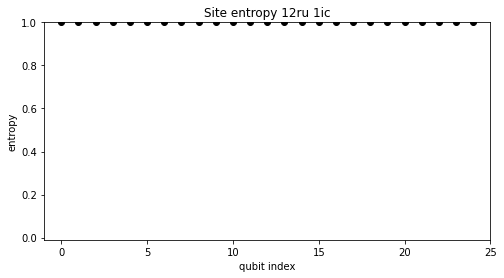

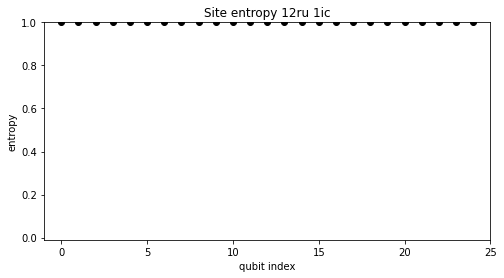

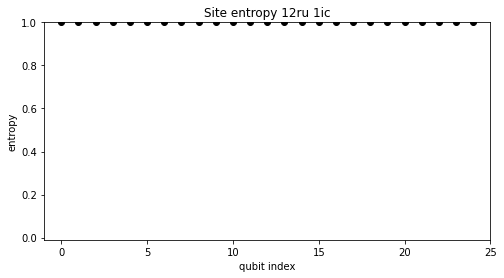

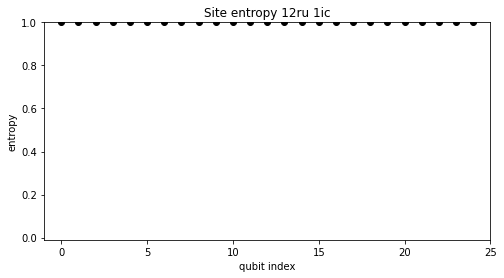

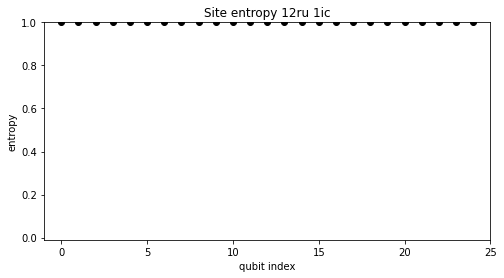

In [31]:
sim_index = 1  # 238, 239 are interesting
sim_rule, sim_ic, _ = list(mutual_information[int(sim_index*ncycles), 0])
sim_entropy = site_entropy[int(sim_index*ncycles):int((sim_index+1)*ncycles)]
for cycle in range(ncycles):
    plt.figure(figsize=(8, 4));
    plt.title(f"Site entropy {sim_rule}ru {sim_ic}ic")
    plt.xlabel("qubit index");
    plt.xlim(-1, 25);
    plt.ylabel("entropy");
    plt.ylim(-0.01, 1);
    plt.scatter(range(nqubits), np.abs(sim_entropy[cycle]), color="black");
#     plt.savefig(f"gifs/entropy/Site_entropy_{sim_rule}ru_{sim_ic}ic_{cycle}cycle.png");
    plt.show()